In [39]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from functions import *
import cobra
from cobra.io import read_sbml_model,load_json_model
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score

In [3]:
model = load_json_model('../data/GSMM_parameters/LP_WCFS1.json')
proB = pd.read_excel('../data/Proteomics/Proteomics_B.xlsx')
gene_info = proB[list(proB.columns[0:5])]
proB = proB[ ['Accession'] + list(proB.columns[-12:])].fillna(0)
uniprot_info = pd.read_csv('../data/Proteomics/uniprotkb_taxonomy_id_220668.tsv',sep='\t')

# Map expression to reactions
* Central carbon metabolism
* Purine and pyrimidine

In [4]:
cc_rxns = ['GLCpts','PGMT','GALU','UDPG4E','MAN6PI','PMANM',
       'PGI','PFK','FBA','TPI','GAPD','PGK','PGM','ENO','PYK',
       'PDH','PTAr','ACKr','PFL','LDH_D','LDH_L','ACCOAC','MACPMT','kaasIII',
       'G6PDH2r','PGL','GND','RPE','RPI','TKT1','TKT2','TALA']

pyr_rxns = ['ASPCT','DHORTS','DHORD6','ORPT','OMPDC','PRPPS',
           'GLUPRT','PRAGS','GARFT','PRFGS','PRAIS','AIRC','PRASCS','ADSL2',
           'AICART','IMPC','IMPD','GMPS2']

In [5]:
def locus2id(locus, uniprot_info):
    temp = uniprot_info[uniprot_info['Gene Names (ordered locus)']==locus] 
    return list(temp['Entry'])[0]
    
    
def get_expr(gene, table, cond):
    if gene not in list(table['Accession']):
        return 0
    temp_pd = (table[table['Accession']==gene]).reset_index().drop(['index'],axis=1)
    expr = sum( [temp_pd[cond+'-B'+str(i)][0] for i in range(1,4) ] )/3
    return expr

def expr_or( gene_list, uniprot_info, expr_table, cond ):
    gids = [ locus2id(x.strip(), uniprot_info) for x in gene_list]
    expr = sum([get_expr(gid, expr_table, cond) for gid in gids])
    return expr

def expr_and( gene_list, uniprot_info, expr_table, cond ):
    gids = [ locus2id(x.strip(), uniprot_info) for x in gene_list]
    expr = min([get_expr(gid, expr_table, cond) for gid in gids])
    return expr

def get_rxn_expr( gpr, uniprot_info, expr_table, cond):
    if '(' not in gpr:
        if 'or' in gpr:
            expr = expr_or( gpr.split('or'), uniprot_info, expr_table, cond )
        else:
            expr = expr_and( gpr.split('and'), uniprot_info, expr_table, cond )
    elif ('(' in gpr) and ('and' in gpr) and ('or' in gpr): # for GLCpts/AIRC special case
        gpr_list = gpr.split('or')
        expr_1 = expr_and( gpr_list[0].replace('(','').replace(')','').split('and'), uniprot_info, expr_table, cond )
        expr_2 = expr_and( gpr_list[1].replace('(','').replace(')','').split('and'), uniprot_info, expr_table, cond )
        expr = expr_1 + expr_2
    elif ('(' in gpr) and ('and' in gpr):
        gpr = gpr.replace('(','').replace(')','')
        expr = expr_and( gpr.split('and'), uniprot_info, expr_table, cond )
        
    return expr  

In [6]:
data = []
for rxn_id in cc_rxns:
    temp = {'RXN':rxn_id}
    gpr = model.reactions.get_by_id( rxn_id ).gene_reaction_rule
    for cond in ['pH6.5','pH5.5','pH5','pH4.5']:
        expr = get_rxn_expr( gpr, uniprot_info, proB, cond)
        temp[cond] = expr
    data.append(temp)
    
cc_rxn_expr = pd.DataFrame(data)
idx_keep = cc_rxn_expr.index[ cc_rxn_expr[cc_rxn_expr.columns[1:5]].sum(axis=1)>0 ]
cc_rxn_expr = (cc_rxn_expr.iloc[idx_keep]).reset_index().drop(['index'],axis=1)

for acid_cond in ['pH5.5','pH5','pH4.5']:
    cc_rxn_expr[ 'Log2FC_'+ acid_cond + 'vsRef' ] = list( np.log2( cc_rxn_expr[acid_cond]/cc_rxn_expr['pH6.5'] ) )
# cc_rxn_expr.to_csv('../data/Proteomics/cc_RXN_lfc.csv',index=None)

In [7]:
data = []
for rxn_id in pyr_rxns:
    temp = {'RXN':rxn_id}
    gpr = model.reactions.get_by_id( rxn_id ).gene_reaction_rule
    for cond in ['pH6.5','pH5.5','pH5','pH4.5']:
        expr = get_rxn_expr( gpr, uniprot_info, proB, cond)
        temp[cond] = expr
    data.append(temp)
pyr_rxn_expr = pd.DataFrame(data)
for acid_cond in ['pH5.5','pH5','pH4.5']:
    pyr_rxn_expr[ 'Log2FC_'+ acid_cond + 'vsRef' ] = list( np.log2( pyr_rxn_expr[acid_cond]/pyr_rxn_expr['pH6.5'] ) )
# pyr_rxn_expr.to_csv('../data/Proteomics/pyr_RXN_lfc.csv' ,index=None)

# Resource allocation between proteome sectors

In [8]:
sectors = {'C':[],'T':[],'A':[],'EPS_syn':[]}
sectors['T'] = ['F9UST3', 'F9UR54','F9UN59','F9UN60'] # lactic acid transporter, GLCpts, 

In [9]:
#A sector includes ribosomal proteins and chaperones
for i in range(len(gene_info.index) ):
    g_name = list(gene_info['Protein Name'])[i]
    if 'ribosomal subunit protein' in g_name or 'ribosomal protein' in g_name :
        sectors['A'].append( list(gene_info['Accession'])[i].strip() )
    if ('Chaperone' in g_name) or ('Chaperonin' in g_name) or ('chaperone' in g_name) or ('chaperonin' in g_name):
        sectors['A'].append( list(gene_info['Accession'])[i].strip() )

In [10]:
column_names = ('query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score').split(', ')
data = []
ffile = open('../data/Genome_HMX2/eps_blast_uniprot.tsv', "rt")
lines = ffile.readlines()
ffile.close()
for line in lines:
    line = line.strip()
    if '#' not in line:
        data.append( line.split('\t'))
blast_result = pd.DataFrame(data ,columns=column_names)
blast_result = blast_result[blast_result['query acc.ver']!='1_990'] #remove AraC
sectors['EPS_syn'] = list( set(blast_result['subject acc.ver']).intersection(set(list(gene_info['Accession']))) )

In [11]:
cc_proteins = []
for rxn_id in cc_rxns:
    genes = model.reactions.get_by_id( rxn_id ).genes
    for g in genes:
        cc_proteins.append( locus2id( g.id, uniprot_info) )
cc_proteins = list(set(cc_proteins).intersection(set(list(gene_info['Accession']))))
sectors['C'] = cc_proteins

In [12]:
sector_expr = []
for sec in ['C','T','A','EPS_syn']:
    data = {'sector':sec}
    temp = proB[proB.Accession.isin(sectors[sec])][proB.columns[1:]]
    temp_dict = dict(temp.sum())
    data.update(temp_dict)
    sector_expr.append(data)
sec_expr_table = pd.DataFrame(sector_expr)
newcol_dict = {x: x.replace('B','') for x in proB.columns[1:]}
sec_expr_table = sec_expr_table.rename( columns= newcol_dict )

In [13]:
old_columns = list(sec_expr_table.columns)
sec_expr_table = sec_expr_table.drop(['pH5-1','pH4.5-3'],axis=1) # outliers are replaced by average values
sec_expr_table['pH5-1'] = (sec_expr_table['pH5-2'] + sec_expr_table['pH5-3'])/2
sec_expr_table['pH4.5-3'] = (sec_expr_table['pH4.5-1'] + sec_expr_table['pH4.5-2'])/2
sec_expr_table = sec_expr_table[old_columns]
sec_expr_table

,sector,pH6.5-1,pH6.5-2,pH6.5-3,pH5.5-1,pH5.5-2,pH5.5-3,pH5-1,pH5-2,pH5-3,pH4.5-1,pH4.5-2,pH4.5-3
0,C,71.375217,71.007676,70.366571,72.086005,71.663209,72.366470,68.441485,68.785790,68.097180,64.812136,65.872762,65.342449
1,T,3.302442,3.315682,3.312254,3.628535,3.585963,3.712618,4.282620,4.223713,4.341526,4.698778,4.595434,4.647106
2,A,67.335147,68.519734,67.355088,60.011841,59.626008,59.950449,66.192857,66.821894,65.563820,64.701355,64.558362,64.629858
3,EPS_syn,16.622409,17.383596,16.784743,16.334366,16.436766,16.358438,27.943913,27.936373,27.951453,29.742320,29.730416,29.736368


In [14]:
sec_ratios = []
for sec in ['C','T','A','EPS_syn']:
    data = {'sector':sec}
    values = sec_expr_table[sec_expr_table['sector']==sec].values[0][1:]
    total = np.array( list(sec_expr_table.sum()[1:]) )
    ratios = values/total
    temp_dict = {list(sec_expr_table.columns[1:])[i]: ratios[i] for i in range(len(sec_expr_table.columns[1:]))}
    data.update(temp_dict)
    sec_ratios.append( data )
ratio_table = pd.DataFrame(sec_ratios)

In [15]:
ratio_table

,sector,pH6.5-1,pH6.5-2,pH6.5-3,pH5.5-1,pH5.5-2,pH5.5-3,pH5-1,pH5-2,pH5-3,pH4.5-1,pH4.5-2,pH4.5-3
0,C,0.449933,0.443170,0.445870,0.474061,0.473612,0.474883,0.410171,0.410006,0.410338,0.395305,0.399818,0.397567
1,T,0.020818,0.020694,0.020988,0.023862,0.023699,0.024363,0.025666,0.025176,0.026161,0.028659,0.027892,0.028275
2,A,0.424465,0.427642,0.426788,0.394657,0.394060,0.393407,0.396695,0.398300,0.395072,0.394630,0.391840,0.393231
3,EPS_syn,0.104784,0.108494,0.106355,0.107420,0.108628,0.107347,0.167468,0.166518,0.168429,0.181406,0.180450,0.180927


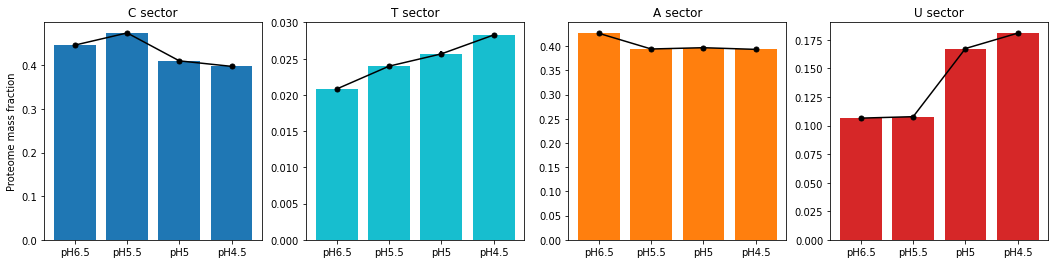

In [16]:
fig, axs = plt.subplots(1,4,figsize=(18,4))
colors = ['tab:blue','tab:cyan','tab:orange','tab:red']
conds = ['pH6.5','pH5.5','pH5','pH4.5']
for i in range(len(ratio_table.index)):
    values = list( ratio_table.iloc[i][1:])
    temp_sec = list(ratio_table['sector'])[i]
    avgs, stds= [],[]
    for j in range(len(conds)):
        avgs.append( np.mean([values[j*3],values[j*3+1],values[j*3+2] ]))
        stds.append( np.std([values[j*3],values[j*3+1],values[j*3+2] ]) )
        
    axs[i].bar(conds, avgs, color =colors[i])
    axs[i].errorbar(conds, avgs, marker='o',markersize=5, elinewidth=2, yerr=stds,color="black")
#     axs[i].scatter(conds, avgs, s=50, color="black")
    if temp_sec == 'EPS_syn':
        axs[i].set_title('U sector')
    else:
        axs[i].set_title(temp_sec+' sector')
axs[0].set_ylabel('Proteome mass fraction');

# Equation discovery for U sector ratio

In [36]:
u_avgs, u_stds=[],[]
values = list( ratio_table.iloc[3][1:])
for i in range(4):
    u_avgs.append(  np.mean([values[i*3],values[i*3+1],values[i*3+2] ]) )
    u_stds.append( np.std([values[i*3],values[i*3+1],values[i*3+2] ])  )

In [37]:
conds = [6.5,5.5,5.0,4.5]
def sigmoid_func(x, k1, k2):
    r0=0.1065;
    r1=0.07443;
    return r0+r1/(1+np.exp(k1*(x-k2)))

popt, pcov = curve_fit( sigmoid_func, conds, u_avgs)
print(popt)

[11.0886758   5.13625503]


0.9999985512629095


Text(5.5, 0.14, 'R2=0.999')

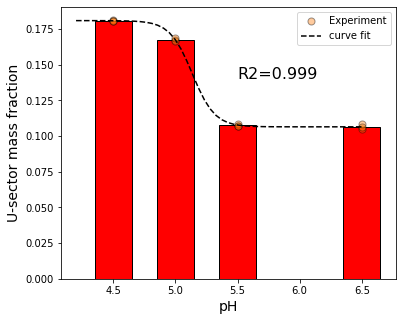

In [48]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.bar(conds, u_avgs, width=0.3, edgecolor = "black", color ='r')
ax.scatter([6.5]*3+[5.5]*3+[5.0]*3+[4.5]*3, list( ratio_table.iloc[3][1:]), color='tab:orange',
           alpha=0.4, edgecolor='black', s=50, label='Experiment')
ax.set_xticks([4.5,5.0,5.5,6.0,6.5]);
temp_pH = np.linspace(4.2, 6.5)
u_preds = [sigmoid_func(x, 11.09, 5.136) for x in temp_pH ]
ax.plot(temp_pH, u_preds, color='black',linestyle='--', label='curve fit')
ax.legend()
ax.set_xlabel('pH',fontsize=14)
ax.set_ylabel('U-sector mass fraction',fontsize=14)

r2 =  r2_score( [sigmoid_func(x, 11.09, 5.136) for x in conds],u_avgs )
print(r2)
ax.text(5.5,0.14,s='R2=0.999',fontsize=16)